In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from datetime import date, timedelta
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import grangercausalitytests
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error

In [3]:
today = date.today()
end_date=today
start_date=date.today()-timedelta(days=5000)
print(start_date)

2008-12-01


In [4]:
og_data=yf.download('NFLX', start=start_date, end=end_date, progress=False)
print(og_data.head())

                Open      High       Low     Close  Adj Close   Volume
Date                                                                  
2008-12-01  3.171429  3.257143  3.112857  3.148571   3.148571  7054600
2008-12-02  3.198571  3.368571  3.154286  3.315714   3.315714  6883800
2008-12-03  3.231429  3.421429  3.218571  3.401429   3.401429  6189400
2008-12-04  3.284286  3.492857  3.235714  3.310000   3.310000  6727000
2008-12-05  3.292857  3.631429  3.225714  3.610000   3.610000  9088100


In [5]:
og_data = og_data.drop(columns=['Adj Close', 'Volume'])

In [468]:
figure=go.Figure(data=[go.Candlestick(x=og_data.index, open=og_data['Open'], high=og_data['High'], low=og_data['Low'], close=og_data['Close'])])
figure.update_layout(title='Netflix Stock Price Analysis', xaxis_rangeslider_visible=False)
figure.show()

                Open       High       Low     Close
Date                                               
2008-12-02  0.027142   0.111428  0.041429  0.167143
2008-12-03  0.032858   0.052858  0.064285  0.085715
2008-12-04  0.052857   0.071428  0.017143 -0.091429
2008-12-05  0.008571   0.138572 -0.010000  0.300000
2008-12-08  0.278572   0.047142  0.282857  0.034286
...              ...        ...       ...       ...
2022-08-03  2.029999  -0.099991  1.539993  5.309998
2022-08-04  2.889999   3.970001  2.630005  3.180008
2022-08-05 -2.379990  -3.450012 -2.180008 -3.130005
2022-08-08  2.190002  13.340012  3.540009  6.710007
2022-08-09  4.129990  -9.760010 -1.760010 -3.550003

[3445 rows x 4 columns]


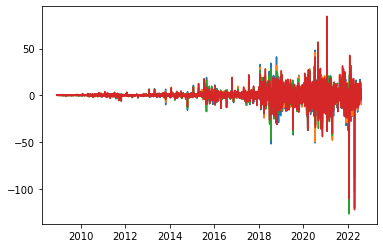

In [6]:
data = og_data.diff()
data = data.dropna()
print(data)
plt.plot(data)

In [7]:
correlation = data.corr()
print(correlation['Close'].sort_values(ascending=False))

Close    1.000000
High     0.749017
Low      0.734927
Open     0.387529
Name: Close, dtype: float64


In [9]:
for i in range(len(data.columns)):
    result = adfuller(data[data.columns[i]])
    if result[1]>0.05:
        print('%s - Series is not stationary' % data.columns[i] )
    else:
        print('%s - Series is stationary' % data.columns[i] )

Open - Series is stationary
High - Series is stationary
Low - Series is stationary
Close - Series is stationary


In [10]:
data_train = data[:int(0.8*len(data))]
data_test = data[int(0.8*len(data)):]
t_i= len(data_train)
print(t_i)
print(data_test.shape)

2756
(689, 4)


In [11]:
model = VAR(data_train)
model.select_order(100).summary()

C:\Users\henry\miniconda3\envs\jupyter_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,7.573,7.582,1946.,7.577
1,6.314,6.358,552.2,6.330
2,5.842,5.922,344.5,5.871
3,5.617,5.732,275.1,5.659
4,5.460,5.610,235.0,5.514
5,5.368,5.554,214.4,5.435
6,5.303,5.525,201.0,5.383
7,5.252,5.509,191.0,5.345
8,5.214,5.506,183.8,5.320
9,5.166,5.494*,175.2,5.284


### Forecasting 10 dates in one go

In [12]:
results = model.fit(9)
lag = results.k_ar
all_predictions = results.forecast(data_train.values[-lag:], steps=10)

In [13]:
predictions = all_predictions[:, 3]
print(predictions)
all_correct_values = data_test[:10].values
correct_values = all_correct_values[:, 3]


[ 0.33414821  0.94362483  0.21486584 -1.09322146  1.36650641  0.62865179
 -1.13950369 -0.36671283 -0.09491305  0.5197944 ]


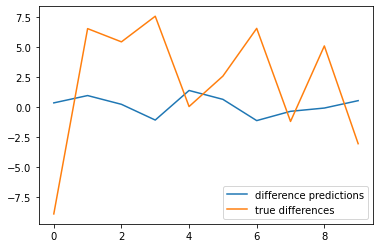

In [14]:
plt.plot(predictions, label='difference predictions')
plt.plot(correct_values, label = 'true differences')
plt.legend()
plt.show()

In [15]:
def diff_to_og_predictor(predictions, test_index):
    end_predictions = np.array([])
    old = og_data.iloc[test_index+1,3]
    for i in range(len(predictions)):
        prediction = old+predictions[i]
        old = prediction
        end_predictions = np.append(end_predictions, prediction)
    return end_predictions

In [16]:
og_predictions = diff_to_og_predictor(predictions, t_i)
print(og_predictions)

[283.44413357 284.38775839 284.60262423 283.50940277 284.87590918
 285.50456096 284.36505727 283.99834444 283.90343139 284.42322579]


In [17]:
length = len(correct_values)
og_correct_vals = og_data.iloc[t_i+1:t_i+length+1, 3]
print(og_correct_vals)

Date
2019-11-13    283.109985
2019-11-14    289.619995
2019-11-15    295.029999
2019-11-18    302.570007
2019-11-19    302.600006
2019-11-20    305.160004
2019-11-21    311.690002
2019-11-22    310.480011
2019-11-25    315.549988
2019-11-26    312.489990
Name: Close, dtype: float64


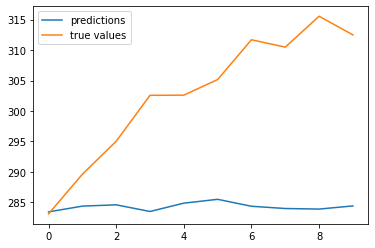

In [18]:
plt.plot(og_predictions, label='predictions')
plt.plot(og_correct_vals.values, label = 'true values')
plt.legend()
plt.show()

In [19]:
print(mean_squared_error(og_predictions, og_correct_vals, squared=False))

21.064624068606477


### Rolling Forecasting Prediction

In [20]:
from sklearn.model_selection import TimeSeriesSplit
n_splits=10
tcsv = TimeSeriesSplit(test_size=1, n_splits=n_splits)
predictions = []
for train_index, test_index in tcsv.split(data):
    train_ds, test_ds = data.iloc[train_index, :], data.iloc[test_index, :]
    model = VAR(train_ds.values).fit(lag)
    all_prediction = model.forecast(train_ds.values[-lag:], steps=1)
    prediction = all_prediction[:, 3]
    predictions.append(prediction)
print(predictions)

[array([-0.40935144]), array([0.21932577]), array([-1.26945844]), array([-0.14091876]), array([-0.14080687]), array([1.30460423]), array([-0.01084767]), array([0.69337406]), array([-0.36203675]), array([0.31823093])]


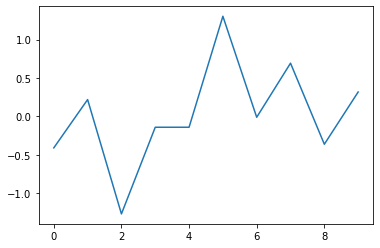

In [21]:
plt.plot(predictions)


In [22]:
preds = diff_to_og_predictor(predictions, len(data)-10)
print(preds)

[226.34064856 226.55997433 225.29051588 225.14959712 225.00879026
 226.31339448 226.30254682 226.99592087 226.63388413 226.95211506]


In [26]:
correct_values = og_data.iloc[-10:, 3]
correct_values

Date
2022-07-27    226.750000
2022-07-28    226.020004
2022-07-29    224.899994
2022-08-01    226.210007
2022-08-02    221.419998
2022-08-03    226.729996
2022-08-04    229.910004
2022-08-05    226.779999
2022-08-08    233.490005
2022-08-09    229.940002
Name: Close, dtype: float64

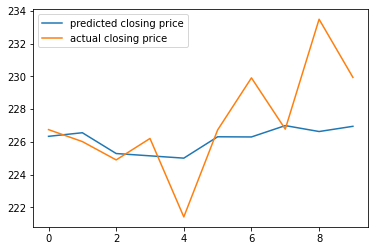

In [27]:
plt.plot(preds, label = 'predicted closing price')
plt.plot(correct_values.values, label = 'actual closing price')
plt.legend()
plt.show()

In [25]:
print(mean_squared_error(preds, correct_values.values, squared=False))

2.89453512445463
